# Detección de anomalías y técnicas de agrupamiento

### Objetivos 

Mediante este trabajo se pretende que poner en práctica la aplicación de los algoritmos de detección de anomalías u outliers y las técnicas de agrupamiento. El objetivo es detectar anomalías, generar y analizar agrupaciones aplicando algoritmos de aprendizaje máquina, con el fin de elegir el mejor método para el conjunto de datos dado. Debe detallar los pasos que hay que realizar para la detección automática de valores inusuales y, por otro lado, analizar los clúster o grupos resultado de aplicar un algoritmo de agrupamiento.


#### Sobre los datos:

Se procesaron automáticamente 2126 cardiotocogramas (CTGs) fetales y se midieron las características diagnósticas respectivas. Los CTGs también fueron clasificados por tres obstetras expertos y se asignó una etiqueta de clasificación de consenso a cada uno de ellos. La clasificación fue tanto con respecto a un patrón morfológico (A, B, C...) como a un estado fetal (N, S, P). Por lo tanto, el conjunto de datos se puede utilizar tanto para experimentos de 10 clases como de 3 clases.

* Fecha: de la examinación
* b: instante de inicio
* e: instante de finalización
* LBE: valor basal (experto médico)
* LB: valor basal (SisPorto)
* AC: aceleraciones (SisPorto)
* FM: movimientos fetales (SisPorto)
* UC: contracciones uterinas (SisPorto)
* ASTV: porcentaje de tiempo con variabilidad a corto plazo anormal (SisPorto)
* mSTV: valor medio de la variabilidad a corto plazo (SisPorto)
* ALTV: porcentaje de tiempo con variabilidad a largo plazo anormal (SisPorto)
* mLTV: valor medio de la variabilidad a largo plazo (SisPorto)
* DL: deceleraciones leves
* DS: deceleraciones severas
* DP: deceleraciones prolongadas
* DR: deceleraciones repetitivas
* Width: ancho del histograma
* Min: frecuencia baja del histograma
* Max: frecuencia alta del histograma
* Nmax: número de picos del histograma
* Nzeros: número de ceros del histograma
* Mode: modo del histograma
* Mean: media del histograma
* Median: mediana del histograma
* Variance: varianza del histograma
* Tendency: tendencia del histograma: -1=asimétrico izquierdo; 0=simétrico; 1=asimétrico derecho
* A: sueño tranquilo
* B: sueño REM
* C: vigilia tranquila
* D: vigilia activa
* AD: patrón acelerativo/decelerativo (situación de estrés)
* DE: patrón decelerativo (estimulación vagal)
* LD: patrón mayormente decelerativo
* FS: patrón plano-sinusoidal (estado patológico)
* SUSP: patrón sospechoso
* CLASS: Código de clase (1 a 10) para clases A a SUSP
* NSP: - Normal=1; Sospechoso=2; Patológico=3

In [8]:
# librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# leemos el conjunto de datos
data = pd.read_csv("./Datos/CTG.csv")
data.head(3)

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,Variab10.txt,12/1/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
1,Fmcs_1.txt,5/3/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
2,Fmcs_1.txt,5/3/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0


De inicio es posible ver sin mucho analisis que podemos eliminar columnas que no nos aportan mucha información: Filename, Date y segfile, b(instante de inicio), e(instante de finalizacion), A(sueño tranquilo), B(sueño REM), C(Vigilia tranquila), D(vigilia activa), DR(deceleraciones repetitivas). Despues de eliminar las columnas es necesario verificar si tenemos celdas vacias.

-- justificar respuesta de acuerdo al punto "tratamiento de missing": Investigar forme al tema si es mejor eliminarlos o tratarlos con un metodo estadistico, de momento los elimino para seguir con la aplicacion

In [10]:
#eliminamos columnas innecesarias
data = data.drop(["FileName","Date",'DR',"SegFile","b","e","A", "B","C", "D" ,"E"], axis=1)
#verificamos datos faltantes
data.isnull().sum()

LBE         3
LB          3
AC          3
FM          2
UC          2
ASTV        2
MSTV        2
ALTV        2
MLTV        2
DL          1
DS          1
DP          1
Width       3
Min         3
Max         3
Nmax        3
Nzeros      3
Mode        3
Mean        3
Median      3
Variance    3
Tendency    3
AD          3
DE          3
LD          3
FS          3
SUSP        3
CLASS       3
NSP         3
dtype: int64

In [11]:
#eliminamos los valores faltantes
data = data.dropna()
data.isnull().sum()

LBE         0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64

In [30]:
categorical = ['NSP','CLASS','Tendency','SUSP']
data[categorical] = data[categorical].astype(str)

In [31]:
#De las variables numéricas, hallar datos estadísticos.
data.describe()

,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,DL,...,DP,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,2126.000000,2126.000000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,133.303857,2.722484,7.241298,3.659925,46.990122,1.332785,9.84666,8.187629,1.570085,...,0.126058,70.445908,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090
std,9.840844,9.840844,3.560850,37.125309,2.847094,17.192814,0.883241,18.39688,5.628247,2.499229,...,0.464361,38.955693,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636
min,106.000000,106.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,0.000000,0.000000,...,0.000000,3.000000,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000
25%,126.000000,126.000000,0.000000,0.000000,1.000000,32.000000,0.700000,0.00000,4.600000,0.000000,...,0.000000,37.000000,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000
50%,133.000000,133.000000,1.000000,0.000000,3.000000,49.000000,1.200000,0.00000,7.400000,0.000000,...,0.000000,67.500000,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000
75%,140.000000,140.000000,4.000000,2.000000,5.000000,61.000000,1.700000,11.00000,10.800000,3.000000,...,0.000000,100.000000,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000
max,160.000000,160.000000,26.000000,564.000000,23.000000,87.000000,7.000000,91.00000,50.700000,16.000000,...,4.000000,180.000000,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000


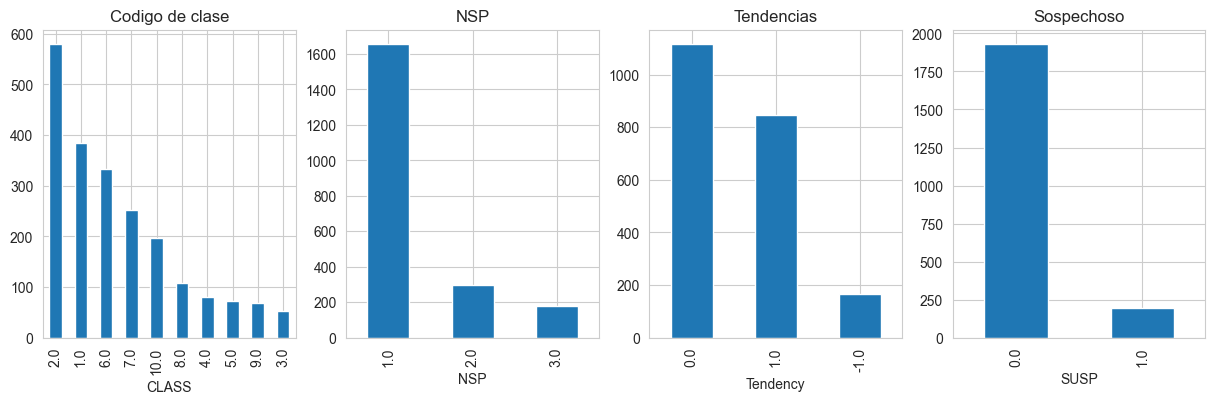

In [12]:
# De las variables categóricas, listar las diferentes categorías y hallar la frecuencia de cada una de ellas

# Obtener el recuento de cada clase
Class_count = data['CLASS'].value_counts()
NSP_count = data['NSP'].value_counts()
tendency_count = data['Tendency'].value_counts()
suspect_count = data['SUSP'].value_counts()
# Crear el gráfico de barras
fig, axes = plt.subplots(1, 4, figsize=(15, 4))

# Añadir etiquetas y título
Class_count.plot(x = Class_count.index, y= Class_count, kind = "bar", title = 'Codigo de clase', ax = axes[0])
NSP_count.plot(x = NSP_count.index, y = NSP_count, kind = "bar", title = 'NSP', ax = axes[1])
tendency_count.plot(x = tendency_count.index, y = tendency_count, kind = "bar", title = 'Tendencias', ax = axes[2])
suspect_count.plot(x = suspect_count, y=suspect_count, kind = "bar", title = 'Sospechoso', ax = axes[3])
# Mostrar el gráfico
plt.show()

destacar puntos importantes del analisis estadistico de las variables categoricas

# correlacion

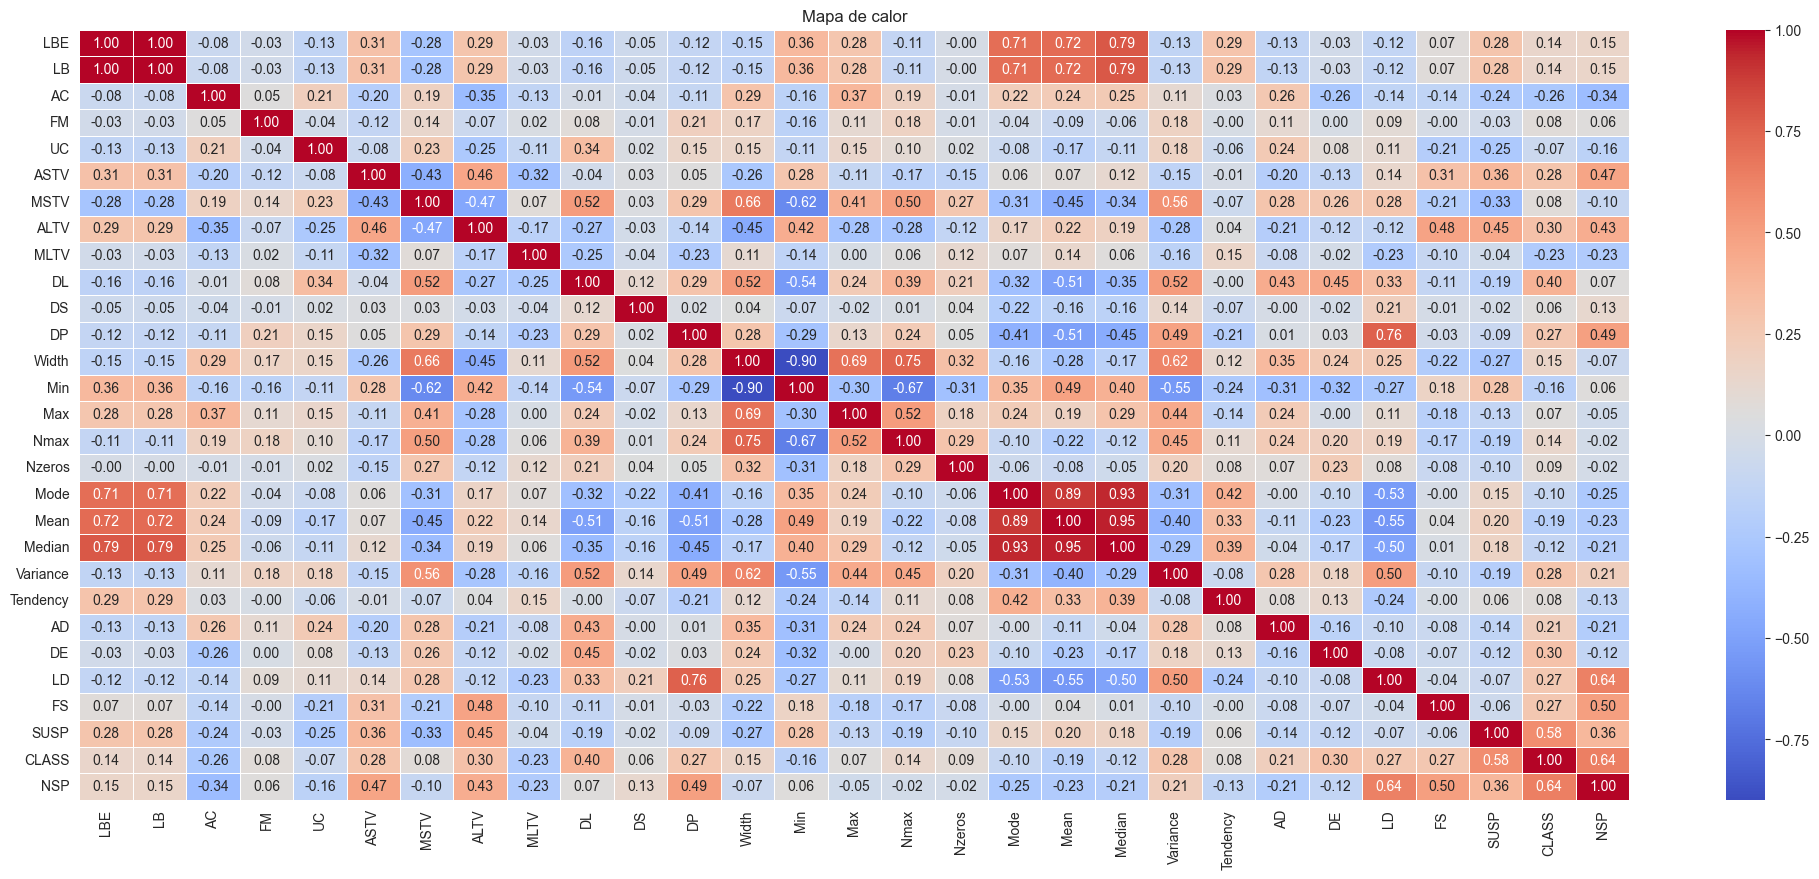

In [13]:
correlacion = data.corr()
plt.figure(figsize=(25,10))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt= '.2f',linewidths=.5)
plt.title('Mapa de calor')
plt.show()


destacar puntos importantes del analisis estadistico del mapa de calor